In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Загрузка данных
df = pd.read_csv('C:/Education/Project/ObesityDataSet.csv')

# Добавление параметра BMI
df['BMI'] = df['Weight'] / (df['Height'] ** 2)


In [39]:
# Преобразование целевой переменной в числовой формат
obesity_levels = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}
df['NObeyesdad_num'] = df['NObeyesdad'].map(obesity_levels)

# Разделение на признаки и целевую переменную
X = df[['BMI', 'NCP']]
y = df['NObeyesdad_num']

In [40]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

print("Данные загружены и подготовлены")
print(f"Размеры данных: {X_train.shape}, {X_test.shape}")
print(f"Классы: {np.unique(y)}")

Данные загружены и подготовлены
Размеры данных: (1583, 2), (528, 2)
Классы: [0 1 2 3 4 5 6]


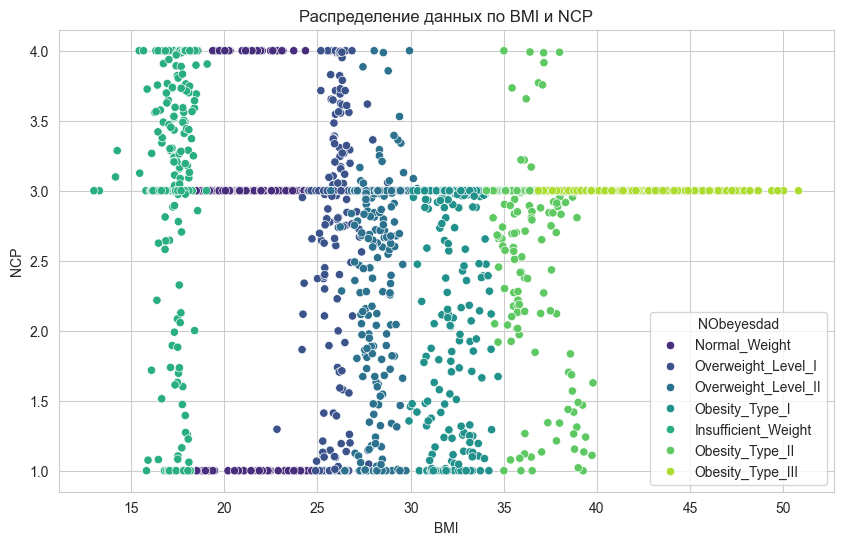

In [41]:
# Визуализация данных
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='BMI',
    y='NCP',
    hue='NObeyesdad',
    palette='viridis'
)
plt.title('Распределение данных по BMI и NCP')
plt.show()


Вывод: Данные визуализированы, видно разделение классов по признакам BMI и NCP

In [42]:
# Обучение простого дерева решений
dt_simple = DecisionTreeClassifier(random_state=42)
dt_simple.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


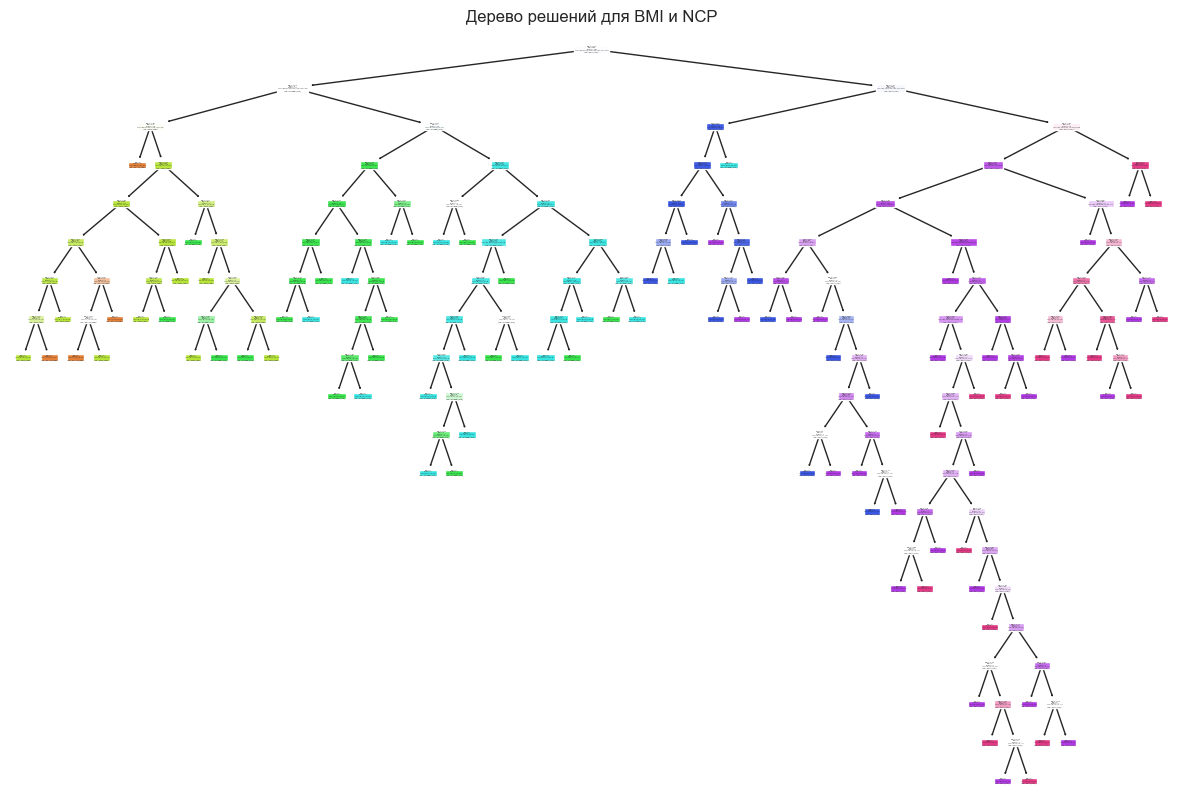

In [43]:
# Визуализация дерева
plt.figure(figsize=(15, 10))
plot_tree(
    dt_simple,
    feature_names=['BMI', 'NCP'],
    class_names=list(obesity_levels.keys()),
    filled=True,
)
plt.title('Дерево решений для BMI и NCP')
plt.show()


Вывод: Построено дерево решений, видна структура разделения данных

Оценка на трейне


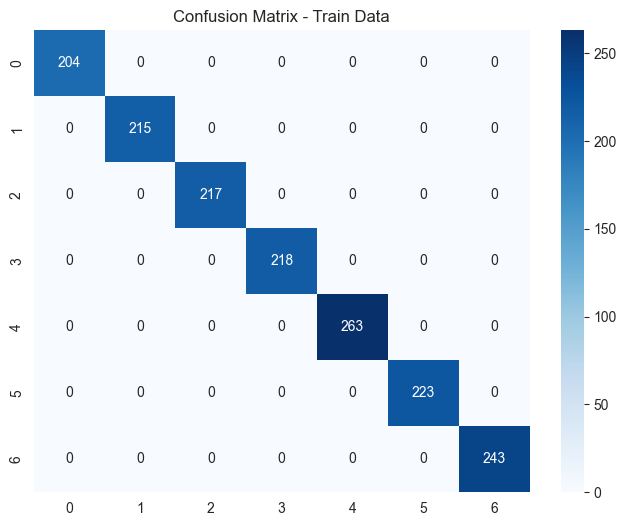

                     precision    recall  f1-score   support

Insufficient_Weight       1.00      1.00      1.00       204
      Normal_Weight       1.00      1.00      1.00       215
 Overweight_Level_I       1.00      1.00      1.00       217
Overweight_Level_II       1.00      1.00      1.00       218
     Obesity_Type_I       1.00      1.00      1.00       263
    Obesity_Type_II       1.00      1.00      1.00       223
   Obesity_Type_III       1.00      1.00      1.00       243

           accuracy                           1.00      1583
          macro avg       1.00      1.00      1.00      1583
       weighted avg       1.00      1.00      1.00      1583

Оценка на кросс-валидации


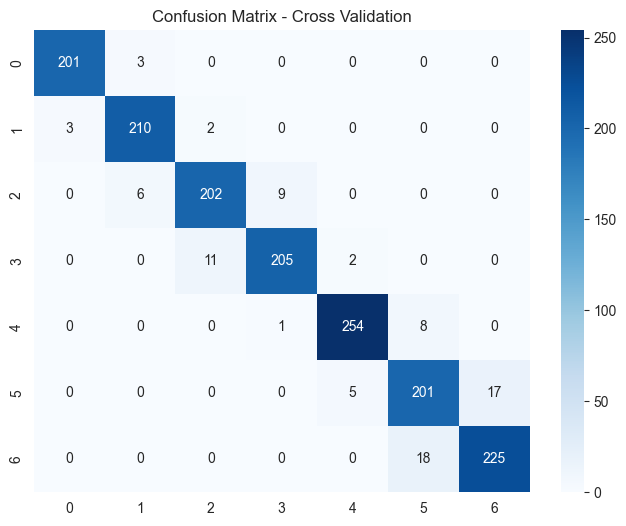

                     precision    recall  f1-score   support

Insufficient_Weight       0.99      0.99      0.99       204
      Normal_Weight       0.96      0.98      0.97       215
 Overweight_Level_I       0.94      0.93      0.94       217
Overweight_Level_II       0.95      0.94      0.95       218
     Obesity_Type_I       0.97      0.97      0.97       263
    Obesity_Type_II       0.89      0.90      0.89       223
   Obesity_Type_III       0.93      0.93      0.93       243

           accuracy                           0.95      1583
          macro avg       0.95      0.95      0.95      1583
       weighted avg       0.95      0.95      0.95      1583



In [44]:
# Оценка на тренировочных данных
y_pred_simple = dt_simple.predict(X_train)
y_pred_cv_simple = cross_val_predict(dt_simple, X_train, y_train, cv=5)

print('Оценка на трейне')
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_train, y_pred_simple), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train Data')
plt.show()

report = classification_report(y_train, y_pred_simple, target_names=obesity_levels.keys())
print(report)

print('Оценка на кросс-валидации')
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_train, y_pred_cv_simple), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Cross Validation')
plt.show()

report_cv = classification_report(y_train, y_pred_cv_simple, target_names=obesity_levels.keys())
print(report_cv)



Вывод: Модель показывает хорошие результаты на тренировочных данных, но есть признаки переобучения

Лучшие параметры: {'class_weight': None, 'max_depth': 4, 'min_samples_leaf': 1}
Лучшее качество на кросс-валидации: 0.951
Classification Report - Train with Best Params:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.99      0.99       204
      Normal_Weight       0.96      1.00      0.98       215
 Overweight_Level_I       0.97      0.93      0.95       217
Overweight_Level_II       0.96      0.97      0.97       218
     Obesity_Type_I       0.98      0.96      0.97       263
    Obesity_Type_II       0.86      0.99      0.92       223
   Obesity_Type_III       1.00      0.90      0.95       243

           accuracy                           0.96      1583
          macro avg       0.96      0.96      0.96      1583
       weighted avg       0.96      0.96      0.96      1583

Classification Report - CV with Best Params:
                     precision    recall  f1-score   support

Insufficient_Weight       0.99      0.98      0.9

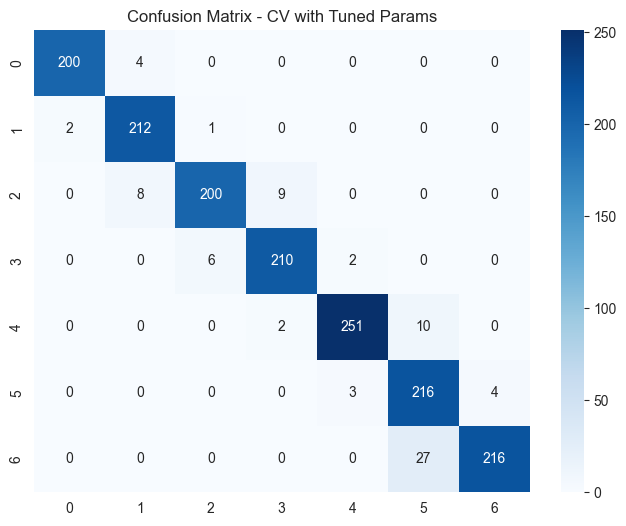

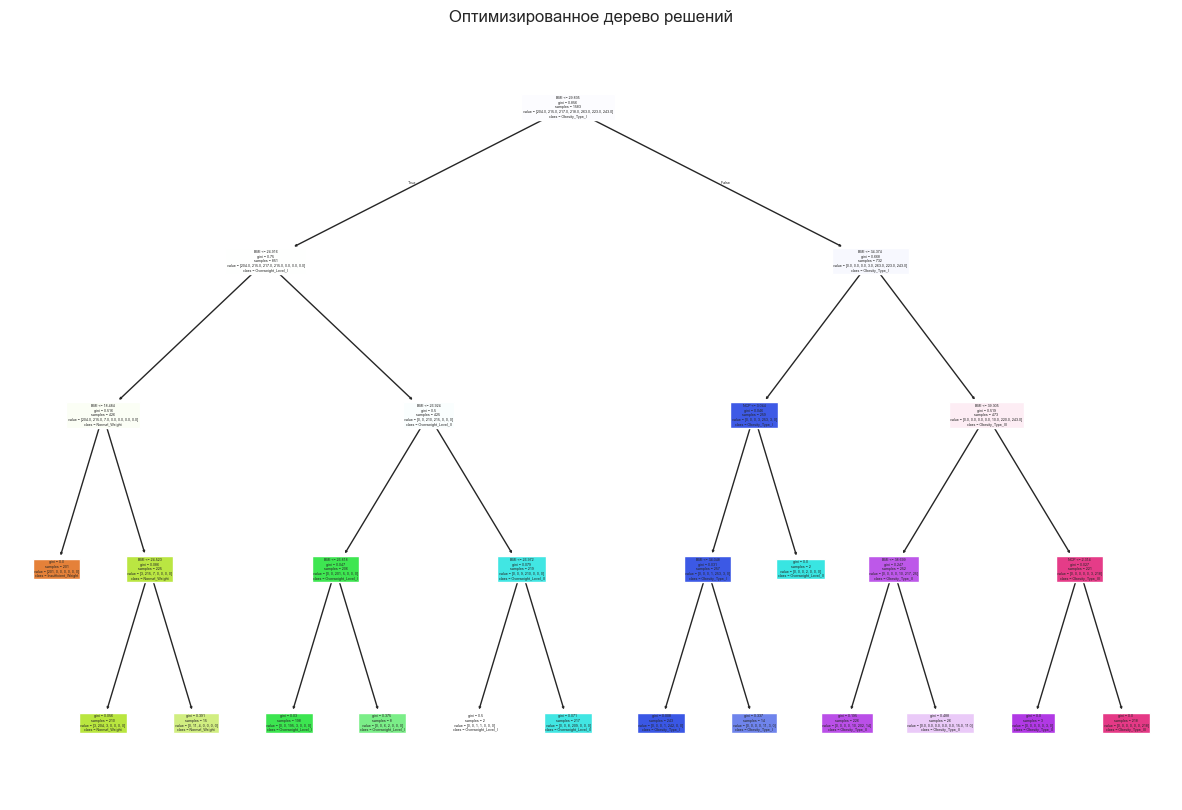

In [45]:
# Подбор гиперпараметров для простой модели
dtc = DecisionTreeClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'max_depth': range(2, 11),
    'min_samples_leaf': range(1, 6),
    'class_weight': [None, 'balanced']
}

gs = GridSearchCV(dtc, param_grid=param_grid, cv=skf, scoring='f1_weighted', n_jobs=-1)
gs.fit(X_train, y_train)

print(f'Лучшие параметры: {gs.best_params_}')
print(f'Лучшее качество на кросс-валидации: {gs.best_score_:.3f}')

y_pred_train = gs.predict(X_train)
print("Classification Report - Train with Best Params:")
print(classification_report(y_train, y_pred_train, target_names=obesity_levels.keys()))

y_pred_cv = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)
print("Classification Report - CV with Best Params:")
print(classification_report(y_train, y_pred_cv, target_names=obesity_levels.keys()))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_train, y_pred_cv), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CV with Tuned Params')
plt.show()

# Визуализация лучшего дерева
plt.figure(figsize=(15, 10))
plot_tree(
    gs.best_estimator_,
    feature_names=['BMI', 'NCP'],
    class_names=list(obesity_levels.keys()),
    filled=True,
)
plt.title('Оптимизированное дерево решений')
plt.show()


Вывод: Подбор гиперпараметров улучшил обобщающую способность модели

In [48]:
# Обучение на всех признаках (кроме целевых)
features_to_drop = ['NObeyesdad', 'NObeyesdad_num', 'BMI']  # BMI уже добавлен отдельно
numeric_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

# Преобразование категориальных признаков
X_full = pd.get_dummies(df[numeric_features + categorical_features], columns=categorical_features)
y_full = df['NObeyesdad_num']

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, random_state=42, stratify=y_full
)

Лучшие параметры (полная модель): {'class_weight': None, 'max_depth': 8, 'min_samples_leaf': 1}
Лучшее качество на кросс-валидации (полная модель): 0.972
Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Insufficient_Weight       0.97      0.98      0.98       204
      Normal_Weight       0.95      0.96      0.96       215
 Overweight_Level_I       0.96      0.94      0.95       217
Overweight_Level_II       0.97      0.95      0.96       218
     Obesity_Type_I       0.97      0.98      0.97       263
    Obesity_Type_II       0.98      0.98      0.98       223
   Obesity_Type_III       1.00      1.00      1.00       243

           accuracy                           0.97      1583
          macro avg       0.97      0.97      0.97      1583
       weighted avg       0.97      0.97      0.97      1583



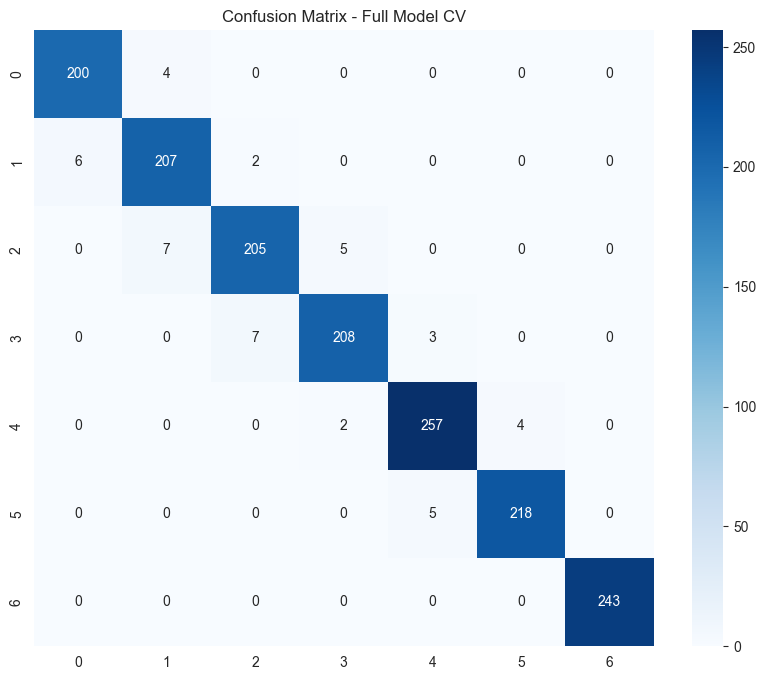

In [49]:
# Подбор гиперпараметров для полной модели
dtc_full = DecisionTreeClassifier(random_state=42)

param_grid_full = {
    'max_depth': range(2, 11),
    'min_samples_leaf': range(1, 6),
    'class_weight': [None, 'balanced']
}

gs_full = GridSearchCV(dtc_full, param_grid=param_grid_full, cv=skf, scoring='f1_weighted', n_jobs=-1)
gs_full.fit(X_train_full, y_train_full)

print(f'Лучшие параметры (полная модель): {gs_full.best_params_}')
print(f'Лучшее качество на кросс-валидации (полная модель): {gs_full.best_score_:.3f}')

y_pred_cv_full = cross_val_predict(gs_full.best_estimator_, X_train_full, y_train_full, cv=skf, n_jobs=-1)
print("Classification Report - Full Model CV:")
print(classification_report(y_train_full, y_pred_cv_full, target_names=obesity_levels.keys()))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_train_full, y_pred_cv_full), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Full Model CV')
plt.show()



Вывод: Полная модель показывает лучшее качество по сравнению с простой

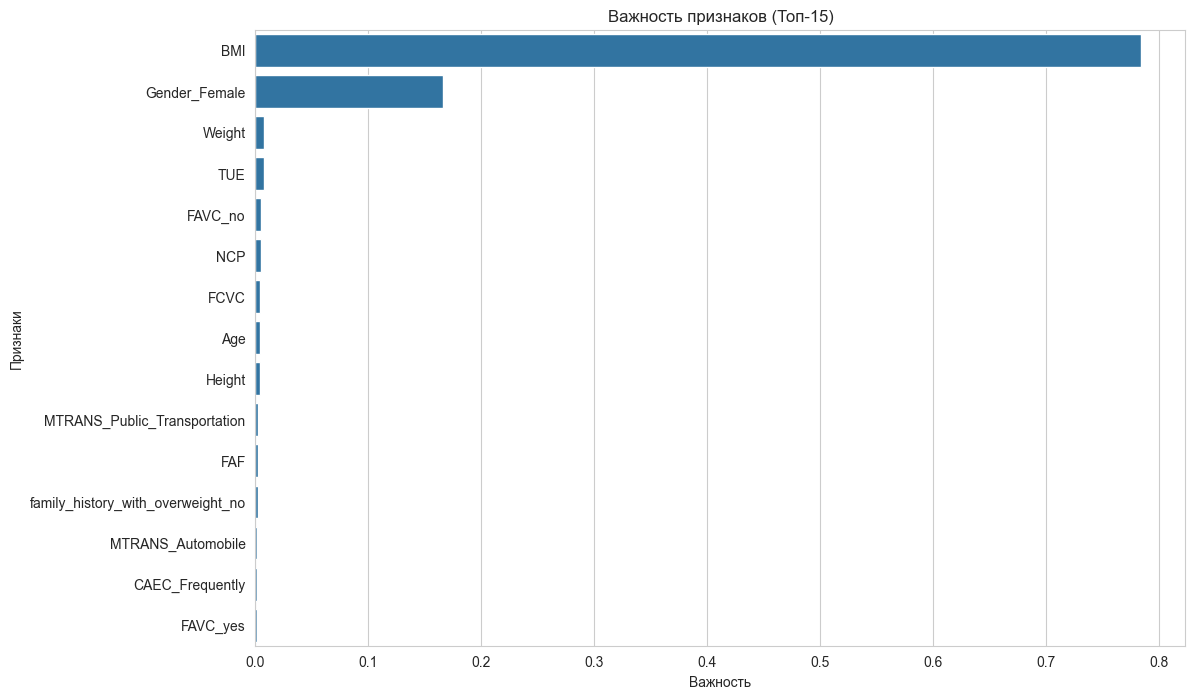

In [50]:
# Анализ важности признаков
feature_importances = gs_full.best_estimator_.feature_importances_
features = X_train_full.columns

plt.figure(figsize=(12, 8))
feature_imp_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
feature_imp_df = feature_imp_df.sort_values('importance', ascending=False).head(15)

sns.barplot(data=feature_imp_df, x='importance', y='feature')
plt.title('Важность признаков (Топ-15)')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

Вывод: BMI является одним из наиболее важных признаков для классификации

In [51]:
# Отбор признаков по важности
selected_features = features[feature_importances > 0.01]
X_train_selected = X_train_full[selected_features]
X_test_selected = X_test_full[selected_features]

print(f"Отобрано признаков: {len(selected_features)}")

Отобрано признаков: 2


In [52]:
#обучение на отобранных признаках
gs_selected = GridSearchCV(dtc_full, param_grid=param_grid_full, cv=skf, scoring='f1_weighted', n_jobs=-1)
gs_selected.fit(X_train_selected, y_train_full)

print(f'Лучшие параметры (отобранные признаки): {gs_selected.best_params_}')
print(f'Лучшее качество (отобранные признаки): {gs_selected.best_score_:.3f}')

y_pred_cv_selected = cross_val_predict(gs_selected.best_estimator_, X_train_selected, y_train_full, cv=skf, n_jobs=-1)
print("Classification Report - Selected Features CV:")
print(classification_report(y_train_full, y_pred_cv_selected, target_names=obesity_levels.keys()))

Лучшие параметры (отобранные признаки): {'class_weight': None, 'max_depth': 4, 'min_samples_leaf': 1}
Лучшее качество (отобранные признаки): 0.969
Classification Report - Selected Features CV:
                     precision    recall  f1-score   support

Insufficient_Weight       0.99      0.98      0.99       204
      Normal_Weight       0.95      0.99      0.97       215
 Overweight_Level_I       0.97      0.92      0.94       217
Overweight_Level_II       0.95      0.96      0.95       218
     Obesity_Type_I       0.97      0.95      0.96       263
    Obesity_Type_II       0.96      0.98      0.97       223
   Obesity_Type_III       1.00      1.00      1.00       243

           accuracy                           0.97      1583
          macro avg       0.97      0.97      0.97      1583
       weighted avg       0.97      0.97      0.97      1583



вывод: обучение на отобранных признаках

# Финальная оценка на тестовых данных

Финальная оценка на тестовых данных:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.97      0.99        68
      Normal_Weight       0.95      1.00      0.97        72
 Overweight_Level_I       0.99      0.95      0.97        73
Overweight_Level_II       0.97      0.96      0.97        72
     Obesity_Type_I       0.98      0.98      0.98        88
    Obesity_Type_II       0.96      0.99      0.97        74
   Obesity_Type_III       0.99      0.99      0.99        81

           accuracy                           0.98       528
          macro avg       0.98      0.98      0.98       528
       weighted avg       0.98      0.98      0.98       528



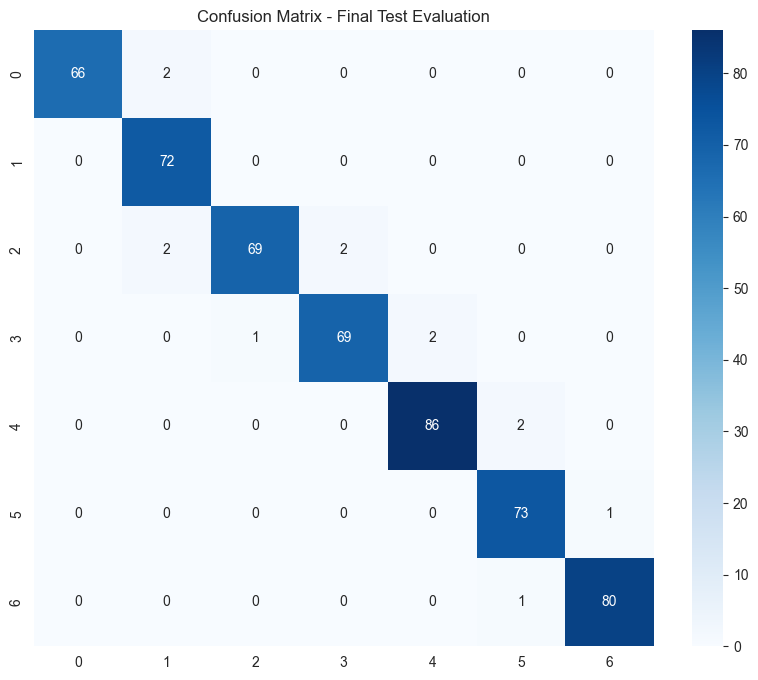

In [37]:
y_test_pred = gs_selected.predict(X_test_selected)
print("Финальная оценка на тестовых данных:")
print(classification_report(y_test_full, y_test_pred, target_names=obesity_levels.keys()))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test_full, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Final Test Evaluation')
plt.show()



Вывод: Финальная модель показывает хорошее качество на тестовых данных

# Общий вывод:
Модель машинного обучения успешно предсказывает уровень ожирения на основе антропометрических и поведенческих данных. Параметр BMI оказался ключевым признаком для классификации. Оптимизация гиперпараметров и отбор признаков позволили создать модель с хорошей обобщающей способностью. Наилучшие результаты достигнуты при использовании всех доступных признаков с подобранными гиперпараметрами дерева решений.